## Seminar 3 - FFT filter bank

4 subband FFT filter bank should be comared with FB from Seminar 3.

In [1]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Load audio file

In [2]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


In [3]:
nTabs = 64
blocksize = 8
nSubbands = 4

FFT via FFT Matrix

In [4]:
I = np.eye(blocksize)
fftMat = np.fft.fft(I)
print(fftMat)

[[  1.00000000e+00+0.j           1.00000000e+00+0.j           1.00000000e+00+0.j
    1.00000000e+00+0.j           1.00000000e+00+0.j           1.00000000e+00+0.j
    1.00000000e+00+0.j           1.00000000e+00+0.j        ]
 [  1.00000000e+00+0.j           7.07106781e-01-0.70710678j
    0.00000000e+00-1.j          -7.07106781e-01-0.70710678j
   -1.00000000e+00+0.j          -7.07106781e-01+0.70710678j
    0.00000000e+00+1.j           7.07106781e-01+0.70710678j]
 [  1.00000000e+00+0.j          -8.26946080e-16-1.j          -1.00000000e+00+0.j
    8.26946080e-16+1.j           1.00000000e+00+0.j          -8.26946080e-16-1.j
   -1.00000000e+00+0.j           8.26946080e-16+1.j        ]
 [  1.00000000e+00+0.j          -7.07106781e-01-0.70710678j
    0.00000000e+00+1.j           7.07106781e-01-0.70710678j
   -1.00000000e+00+0.j           7.07106781e-01+0.70710678j
    0.00000000e+00-1.j          -7.07106781e-01+0.70710678j]
 [  1.00000000e+00+0.j          -1.00000000e+00+0.j           1.00000000

Compute blockwise FFT on blocks of 8 samples:

In [5]:
newlength = audio.shape[0] - (audio.shape[0] % blocksize) # length so it fits into blocks of size blocksize
stackedBlocks = np.reshape(audio[0:newlength],(int(newlength/blocksize), blocksize))
transformed = np.dot(stackedBlocks, fftMat)
print(stackedBlocks.dtype)

int16


In [6]:
for i in range(blocksize):
    print("Playing Downsampled signal at phase {}".format(i))
    sound.sound(np.real(stackedBlocks[:,i]),int(fs/blocksize))

Playing Downsampled signal at phase 0
* done
Playing Downsampled signal at phase 1
* done
Playing Downsampled signal at phase 2
* done
Playing Downsampled signal at phase 3
* done
Playing Downsampled signal at phase 4
* done
Playing Downsampled signal at phase 5
* done
Playing Downsampled signal at phase 6
* done
Playing Downsampled signal at phase 7
* done


In [21]:
for i in range(blocksize):
    print("Playing subband signal k = {}".format(i))
    normalized = (transformed[:,i] / np.max(np.abs(transformed[:,i]))) * 32767 #normalize to max range of integer
    sound.sound(np.real(normalized),int(fs/blocksize))

Playing subband signal k = 0
* done
Playing subband signal k = 1
* done
Playing subband signal k = 2
* done
Playing subband signal k = 3
* done
Playing subband signal k = 4
* done
Playing subband signal k = 5
* done
Playing subband signal k = 6
* done
Playing subband signal k = 7
* done


### Task b)

Plot of the resulting subband filters and filtered subbands.

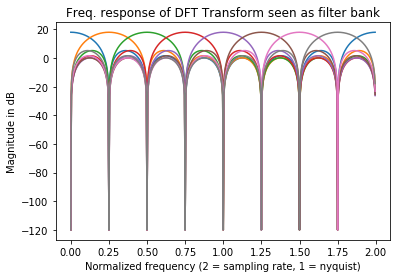

In [8]:
for bandIx in range(blocksize):
    w,h = sig.freqz(np.flipud(fftMat[:,bandIx]),whole=True)
    plt.plot(w/np.pi, 20*np.log10(abs(h)+1e-6))
plt.title('Freq. response of DFT Transform seen as filter bank')
plt.xlabel('Normalized frequency (2 = sampling rate, 1 = nyquist)')
plt.ylabel('Magnitude in dB')
plt.show()

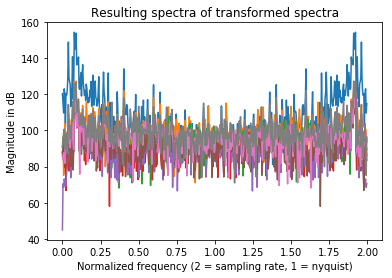

In [9]:
for bandIx in range(blocksize):
    w,h = sig.freqz(transformed[:, bandIx],whole=True)
    plt.plot(w/np.pi, 20*np.log10(abs(h)+1e-6))
plt.title('Resulting spectra of transformed spectra')
plt.xlabel('Normalized frequency (2 = sampling rate, 1 = nyquist)')
plt.ylabel('Magnitude in dB')
plt.show()

### Task c)
Apply inverse FFT to obtain reconstructed signal.

In [10]:
reconBlocks = np.dot(transformed, np.linalg.inv(fftMat))
reconAudio = np.reshape(reconBlocks, reconBlocks.shape[0] * reconBlocks.shape[1])

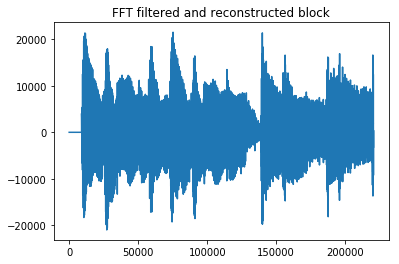

In [11]:
plt.plot(np.real(reconAudio))
plt.title('FFT filtered and reconstructed block')
plt.show()

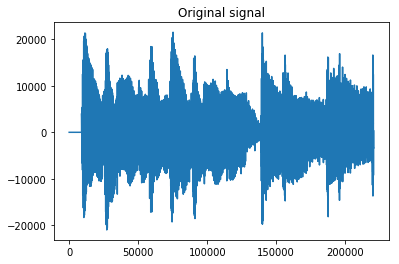

In [12]:
plt.plot(audio)
plt.title('Original signal')
plt.show()

Listen to original and reconstructed signal:

In [13]:
print("Playing Original")
sound.sound(audio,fs)

Playing Original
* done


In [14]:
print("Playing Reconstructed signal")
sound.sound(np.real(reconAudio),fs)

Playing Reconstructed signal
* done


### Task 2
Compare filter responses of FFT with previous filter responses

In [15]:
def sinc(x):
    return (np.sin(x)/x)

def sincImpulse(N,wc):
    n = np.arange(0,N)
    delay = (N-1)/2.0
    h = (wc/np.pi)*sinc((n-delay)*wc)
    return h

def cosModulator(N,w0):
    n = np.arange(0,N)
    m = np.cos(w0*n)
    return m

def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

In [16]:
def errfunc(h):
    numfreqsamples=1024
    #desired passband:
    pb=int(numfreqsamples*0.05)
    tb=int(numfreqsamples*0.01)
    w, H = sig.freqz(h,1,numfreqsamples)
    H_desired=np.concatenate((np.ones(pb), np.zeros(numfreqsamples-pb)))
    weights = np.concatenate((np.ones(pb), np.zeros(tb), 100*np.ones(numfreqsamples-pb-tb)+1000*np.arange(numfreqsamples-pb-tb)))
    err = np.sum(np.abs(H-H_desired)*weights)
    return err

In [17]:
# start off with a raised cosine window instead of random numbers to have a unvarying end result
opt_start = raisedCosWinow(nTabs)
#omega, H =sig.freqz(-1.0*opt_start)
#plt.plot(omega, 20*np.log10(abs(H)+1e-6))
#plt.show()
minout = opt.minimize(errfunc, opt_start, tol=1e-6)
h = minout.x
h_opt = abs(h) / np.amax(abs(h))

In [18]:
fb = []

#LP
wLp_sinc = np.pi * 0.25
prototype_LpOpt = sincImpulse(nTabs, wLp_sinc) * h_opt
lp = 0.1 * prototype_LpOpt / max(abs(prototype_LpOpt))
fb.append(lp)

#BP1
prototype_BpOpt = sincImpulse(nTabs, np.pi * 0.1) * h_opt
mod_bp1 = cosModulator(nTabs, (2*1+1) * np.pi/(2*4))
bp1 = prototype_BpOpt * mod_bp1
bp1 = 0.1 * bp1 / max(abs(bp1))
fb.append(bp1)

#BP2
mod_bp2 = cosModulator(nTabs, (2*2+1) * np.pi/(2*4))
bp2 = prototype_BpOpt * mod_bp2
bp2 = 0.1 * bp2 / max(abs(bp2))
fb.append(bp2)


#HP
mod_hp = cosModulator(nTabs, np.pi)
hp = prototype_LpOpt * mod_hp
hp = 0.1 * hp / max(abs(hp))
fb.append(hp)

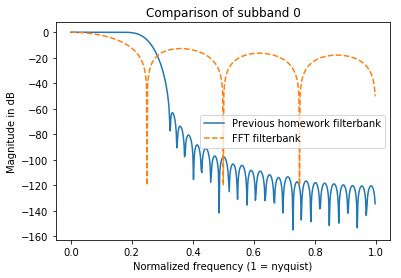

In [19]:
compare_band = 0

# previous homework filterbank
wFb, hFb = sig.freqz(fb[compare_band])
hFb = (1/np.max(np.abs(hFb))) * hFb #normalize to 0dB for plot
plt.plot(wFb/(np.pi),20*np.log10(np.abs(hFb)))

# fft filterbank
wFFT, hFFT = sig.freqz(np.flipud(fftMat[:, compare_band]))
hFFT = (1/np.max(np.abs(hFFT))) * hFFT #normalize to 0dB for plot
plt.plot(wFFT/np.pi, 20*np.log10(abs(hFFT)+1e-6), '--')

plt.legend(['Previous homework filterbank', 'FFT filterbank'])
plt.xlabel('Normalized frequency (1 = nyquist)')
plt.ylabel('Magnitude in dB')
plt.title('Comparison of subband {}'.format(compare_band))
plt.show()

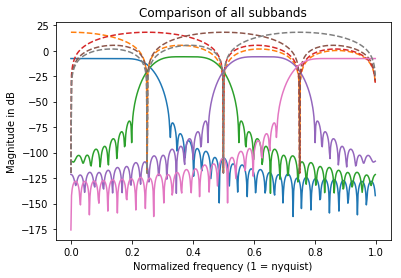

In [20]:
for bandIx, h in enumerate(fb):
    # previous homework filterbank
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
    
    # fft filterbank
    w,hFFT = sig.freqz(np.flipud(fftMat[:,bandIx]))
    plt.plot(w/np.pi, 20*np.log10(abs(hFFT)+1e-6), '--')

plt.xlabel('Normalized frequency (1 = nyquist)')
plt.ylabel('Magnitude in dB')
plt.title('Comparison of all subbands')
plt.show()